In [4]:
from functools import wraps
import numpy as np
import pandas as pd
from scipy import integrate, optimize, stats
import matplotlib.pyplot as plt

## References

 - Gerardo Chowell, *Fitting dynamic models to epidemic outbreaks withquantified uncertainty: A primer for parameter uncertainty,identifiability, and forecasts*, KeAi Infectious Disease Modelling (2017) 379-398
 - Cécile Viboud, *A generalized-growth model to characterize the early ascendingphase of infectious disease outbreaks*, Elsevier Epidemics (2016) 27-37

### Useful Links

 
 - https://www.sciencedirect.com/science/article/pii/S2468042717300234
 - https://www.sciencedirect.com/science/article/pii/S1755436516000037
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
 - https://stackoverflow.com/questions/60791453/how-can-i-fix-this-typeerror-when-fitting-ode-with-scipy
 
 

In [5]:
t = np.arange(0, 50)

## GRM


The Generalized Richards Model:

$$
\dot{C}(t) = \frac{\mathrm{d}C}{\mathrm{d}t} = r C^p\left[1-\left(\frac{C}{K}\right)^a\right]
$$

Where $C(t)$ is the cumulative number of case, $r \in \mathbb{R}^+$ is the **growth rate** and $p \in (0,1)$ is the **deceleration of growth**, $K \in \mathbb{R}^+$ is the **size of the epidemic** and $a$ is the deviation from the S-shaped dynamic.

In [6]:
def GRM_ODE(t, C, r, p, K, a):
    return r*np.power(C, p)*(1-np.power((C/K), a))

In [10]:
def GRM(t, C0, r, p, K, a, rtol=1e-6):
    return integrate.solve_ivp(GRM_ODE, (t[0], t[-1]), [C0], t_eval=t, args=(r, p, K, a), rtol=rtol).y[0]

In [15]:
def factory(C0, rtol=1e-6):
    def wrapper(t, r, p, K, a):
        return GRM(t, C0, r, p, K, a, rtol=1e-6)
    return wrapper

In [16]:
y2 = GRM(t, 2321, 1.19, 0.83, 1.76e5, 1.72)

In [17]:
popt2, pcov2 = optimize.curve_fit(
    factory(2321), t, y2, p0=(1, 1, 1e6, 1), bounds=([0.1, 0.01, 50, 0.1], [10, 1, 1e7, 10]),
    gtol=1e-6, max_nfev=10000)
(popt2, pcov2)

(array([1.19e+00, 8.30e-01, 1.76e+05, 1.72e+00]),
 array([[ 4.71542317e-20, -4.31728322e-21, -1.71997249e-17,
          2.88017130e-20],
        [-4.31728322e-21,  3.95465514e-22,  1.61018792e-18,
         -2.65090160e-21],
        [-1.71997249e-17,  1.61018792e-18,  6.33146605e-14,
         -1.45830921e-17],
        [ 2.88017130e-20, -2.65090160e-21, -1.45830921e-17,
          1.87755353e-20]]))

In [96]:
print(popt2)

[2.321e+03 1.190e+00 8.300e-01 1.760e+05 1.720e+00]


In [98]:
print(pd.DataFrame(pcov2))

              0             1             2             3             4
0  4.066940e-19 -6.109083e-22  5.075394e-23  4.857699e-20 -1.967610e-22
1 -6.109083e-22  1.073130e-24 -9.047300e-26 -1.296757e-22  3.905187e-25
2  5.075394e-23 -9.047300e-26  7.637737e-27  1.137094e-23 -3.329493e-26
3  4.857699e-20 -1.296757e-22  1.137094e-23  2.145475e-19 -7.158153e-23
4 -1.967610e-22  3.905187e-25 -3.329493e-26 -7.158153e-23  1.570960e-25


In [90]:
y2f = GRM(t, *popt2)

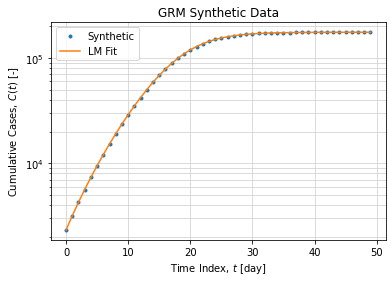

In [94]:
fig, axe = plt.subplots()
axe.semilogy(t, y2, '.', label='Synthetic')
axe.semilogy(t, y2f, label='LM Fit')
axe.set_title("GRM Synthetic Data")
axe.set_xlabel(r"Time Index, $t$ [day]")
axe.set_ylabel(r"Cumulative Cases, $C(t)$ [-]")
axe.legend()
axe.grid(which='both', color='lightgray')

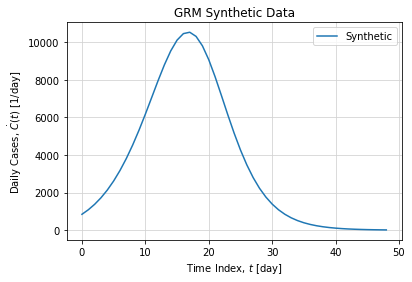

In [95]:
fig, axe = plt.subplots()
axe.plot(t[:-1], np.diff(y2)/np.diff(t), '-', label='Synthetic')
#axe.semilogy(t, y2f, label='LM Fit')
axe.set_title("GRM Synthetic Data")
axe.set_xlabel(r"Time Index, $t$ [day]")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.legend()
axe.grid(which='both', color='lightgray')

## Refactoring

### Factory for ODE

We create a factory for ODE adjustment

In [10]:
def ODEFitFactory(f):
    """
    Factory to adjust signature function of the Integrated ODE solved by scipy.integrate.solve_ivp
    to the optimizer provided by scipy.optimize.curve_fit
    The first argument args[0] is the initial condition of the IVP
    The rest of arguments args[1:] are parameters of the Fit
    """
    @wraps(f)
    def inner(t, *args):
        return integrate.solve_ivp(f, (t[0], t[-1]), args[0:], t_eval=t, args=args[1:]).y[0]
    return inner

In [11]:
def ODEFit(ode, x, y, p0=None, bounds=(-np.inf, np.inf)):
    """
    Fit ODE parameters using optimizer provided by scipy.optimize.curve_fit
    """
    odef = ODEFitFactory(ode)
    popt, pcov = optimize.curve_fit(odef, x, y, p0=p0, bounds=bounds)
    return popt, pcov

In [12]:
data = pd.read_json("https://epistat.sciensano.be/Data/COVID19BE_CASES_AGESEX.json")

In [13]:
data.columns

Index(['DATE', 'PROVINCE', 'REGION', 'AGEGROUP', 'SEX', 'CASES'], dtype='object')

In [14]:
data["DATE"] = pd.to_datetime(data["DATE"])

In [15]:
tso = data.groupby("DATE")["CASES"].sum().to_frame()

In [16]:
from scipy import signal

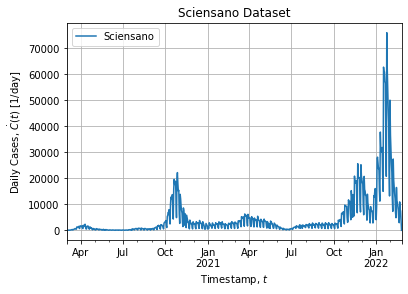

In [104]:
axe = tso.plot()
axe.legend(["Sciensano"])
axe.set_title("Sciensano Dataset")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

In [108]:
ts = tso.rolling(14).mean()
#ts = signal.savgol_filter(tso["CASES"].values, 9, 3)

In [109]:
tk = "2021-12-21"

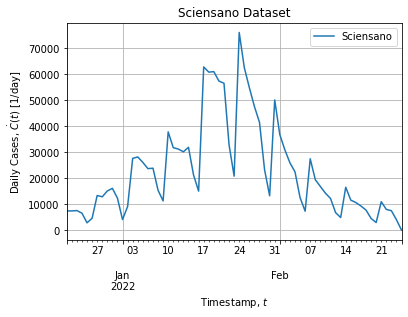

In [110]:
axe = tso.loc[tso.index >= tk].plot()
axe.legend(["Sciensano"])
axe.set_title("Sciensano Dataset")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

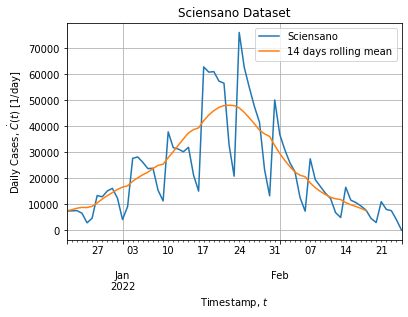

In [117]:
#axe = 
axe = tso[ts.index >= tk].plot()
ts[ts.index >= tk].shift(-7).plot(ax=axe)
axe.legend(["Sciensano", "14 days rolling mean"])
axe.set_title("Sciensano Dataset")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

In [20]:
cts = tso[tso.index >= tk].cumsum()
tp = (cts.index - pd.Timestamp(tk)) // pd.Timedelta('1d')
cts.index = tp
C = cts["CASES"].values

In [21]:
popt2, pcov2 = optimize.curve_fit(GRM, tp, C, p0=(2e4, 1.1, 0.8, 1.5e6, 1),
                                  bounds=([1, 0.1, 0.1, 50, 0.1], [1e7, 10, 1, 1e7, 10]),
                                  gtol=1e-9, max_nfev=10000)
(popt2, pcov2)

KeyboardInterrupt: 

In [ ]:
n = np.arange(100)
c = GRM(tp, *popt2)
cex = GRM(n, *popt2)

In [ ]:
fig, axe = plt.subplots()
axe.plot(tp, C, ".", label="Data")
axe.plot(tp, c, label="LM Fit")
#axe.plot(n, cex, label="LM Fit")
axe.legend()
axe.set_title("GRM Model for Covid omicron wave")
axe.set_xlabel("Time index, $t_i$ [day]")
axe.set_ylabel("Cumulative cases, $C(t_i)$ [-]")
axe.grid()

In [ ]:
fig, axe = plt.subplots()
axe.plot(tp[:-1], np.diff(C), ".-", label="Data")
axe.plot(tp[:-1], np.diff(c), label="LM Fit")
#axe.plot(n[:-1], np.diff(cex), label="LM Fit")
axe.legend()
axe.set_title("GRM Model for Covid omicron wave")
axe.set_xlabel("Time index, $t_i$ [day]")
axe.set_ylabel("Daily cases, $\dot{C}(t_i)$ [1/day]")
axe.grid()

In [ ]:
df = ts[ts.index >= tk].cumsum()
df["index"] = (df.index - pd.Timestamp(df.index[0])) // pd.Timedelta('1d')
df.sample(5)

In [ ]:
def solve(frame):
    t = frame["index"].values
    C = frame["CASES"].values
    popt, pcov = optimize.curve_fit(GRM, t, C, p0=(2e4, 1.1, 0.8, 1.5e6, 1),
                                  bounds=([1, 0.1, 0.1, 50, 0.1], [1e7, 10, 1, 1e7, 10]),
                                  gtol=1e-9, max_nfev=10000)
    return popt

In [ ]:
solve(df)

In [ ]:
params = []
for k in range(200):
    x = df.sample(frac=0.9).sort_index()
    p = solve(x)
    params.append(p)
    print(p)

In [ ]:
df = pd.DataFrame(params, columns=["C", "r", "p", "K", "a"])
df.to_csv("bootstrap_smooth.csv", index=False)
df.sample(5)

In [ ]:
df.describe()

In [ ]:
for k in df:
    fig, axe = plt.subplots()
    df[k].plot(kind="kde", ax=axe)
    axe.set_title(k)

In [ ]:
fig, axe = plt.subplots()
for row in df.itertuples():
    #print(*row)
    c = GRM(tp, *row[1:])
    axe.plot(tp, c, color="lightgrey")
    #axe.plot(df["index"], df[])